In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


# plt.rcParams['animation.writer'] = 'avconv'
%matplotlib inline

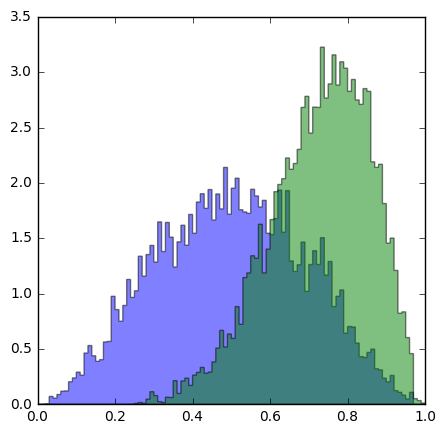

In [11]:
s_raw = np.random.beta(8,3, 8000)
b_raw = np.random.beta(3,3, 8000)

weight =np.concatenate((np.random.binomial(10,0.5, 8000)/100.0,np.random.binomial(10,0.5, 8000)/1.0))
y =np.concatenate((np.ones(s_raw.shape[0]),np.zeros(b_raw.shape[0])))

data = np.concatenate((s_raw,b_raw))

fig = plt.figure(figsize=(5,5))
bb,_,_ = plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5, normed=True)
ss,_,_ = plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5, normed=True)
# plt.yscale('log')
plt.show()

In [5]:
from tools import kde
from scipy.integrate import quad

100
100
(0.9994055274771623, 8.096335531033402e-10)
(0.9994670787086117, 4.7294503411487995e-14)


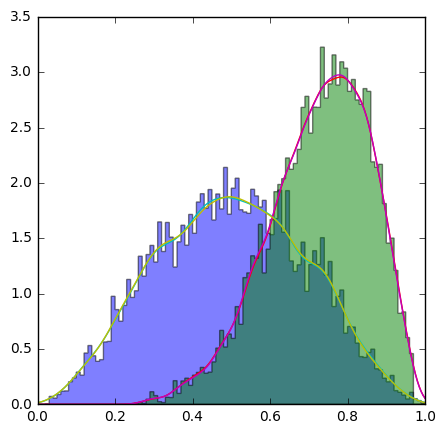

In [12]:

pdf_s = kde.gaussian_kde(data[y==1])
pdf_b = kde.gaussian_kde(data[y==0])

x  = np.linspace(0,1, 200)
pss = pdf_s(x)
pbb = pdf_b(x)

print len(ss)
print len(bb)

fig = plt.figure(figsize=(5,5))
bb,_,_ = plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5, normed=True)
ss,_,_ = plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5, normed=True)

plt.plot(x, pss, label='kde-s')
plt.plot(x, pbb, label='kde-b')

plt.plot(x, kde.gaussian_kde(data[y==1], weights=weight[y==1])(x), label='kde-s')
plt.plot(x, kde.gaussian_kde(data[y==0], weights=weight[y==0])(x), label='kde-b')


ss_fun = lambda x : pdf_s(x)
bb_fun = lambda x : pdf_b(x)

print quad(ss_fun, 0, 1)
print quad(bb_fun, 0, 1)
print pdf_s
# plt.yscale('log')
plt.show()

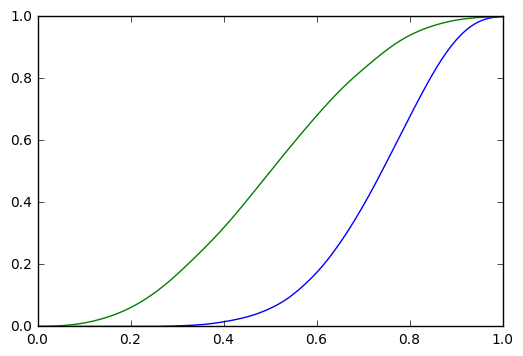

In [14]:
s_ = kde.gaussian_kde(data[y==1], weights=weight[y==1])
b_ = kde.gaussian_kde(data[y==0], weights=weight[y==0])

plt.plot(x, [s_.integrate_box_1d(0,x[i]) for i in range(x.shape[0])], label='kde-s')
plt.plot(x, [b_.integrate_box_1d(0,x[i]) for i in range(x.shape[0])], label='kde-b')

In [19]:
from scipy import optimize
from scipy.integrate import quad

class binner_base(object):
    """ Abstract class for classification based binning
    """
    def __init__(self, nbins, range):
        self.nbins = nbins
        self.range = range
        raise NotImplementedError('Method or function has not been implemented yet')
    def fit(self, X, y, sample_weights=None):
        raise NotImplementedError('Method or function has not been implemented yet')
        return self
    
class costum_bounds(object):
    def __init__(self, xmax=[1.1,1.1], xmin=[-1.1,-1.1] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin
    
class zbinner(binner_base):
    def __init__(self,nbins, range, drop_last_bin=True, 
                 fix_upper=True, fix_lower=False, use_kde_density = True):
        self.nbins = nbins
        self.range = range
        self.drop_last_bin = drop_last_bin
        self.X = None
        self.y = None
        self.pdf_s = None
        self.pdf_b = None
        self.fix_upper = fix_upper
        self.fix_lower = fix_lower
        self.breg = 0
        self.use_kde_density = use_kde_density
        self.sample_weights = None
        self.scan = {"bounds": [],"cost": []}
        
    def _fom_(self,s,b,breg=10):
        c = np.zeros(s.shape[0])
        c[(s == 0) & (b==0)] = 0
        c[(s+b)!=0] = s[(s+b)!=0] / np.sqrt((s+b+breg)[(s+b)!=0])
        return c
    def binned_score(self,x):
        x = np.sort(x)
        nb_,_  = np.histogram(self.X[self.y==0],bins=x, range=self.range, weights=self.sample_weights[self.y==0])
        ns_,_  = np.histogram(self.X[self.y==1],bins=x, range=self.range, weights=self.sample_weights[self.y==1])
        if nb_.shape !=  ns_.shape :    
            return 0
        else:
            return self._fom_(ns_, nb_)
    def binned_score_density(self,x):
        x = np.sort(x)
        ns_= self.sample_weights[self.y==1].sum()*np.array([self.pdf_s.integrate_box_1d(x[i], x[i+1]) for i in range(x.shape[0]-1)])
        nb_= self.sample_weights[self.y==0].sum()*np.array([self.pdf_b.integrate_box_1d(x[i], x[i+1]) for i in range(x.shape[0]-1)])
        if nb_.shape !=  ns_.shape :    
            return 0
        else:
            return self._fom_(ns_, nb_)
    def cost_fun(self,x):
        z  = None
        if self.use_kde_density:
            z  = self.binned_score_density(x)
        else:
            z  = self.binned_score(x)
        self.scan['bounds'].append(np.sort(x))
        self.scan['cost'  ].append(-np.sqrt((z**2).sum()))
        return -np.sqrt((z**2).sum())
    def fit(self, X, y, sample_weights=None):
        self.X = X
        self.y = y 
        if sample_weights is not None:
            self.sample_weights = sample_weights
        else:
            self.sample_weights = np.ones(X.shape[0])
        
        x_init = np.linspace (self.range[0],self.range[1],self.nbins+1)
        np.random.seed(555)
        min_args = {"method": "BFGS"}
        self.pdf_s = kde.gaussian_kde(self.X[self.y==1], weights=self.sample_weights[self.y==1])
        self.pdf_b = kde.gaussian_kde(self.X[self.y==0], weights=self.sample_weights[self.y==0])
        
        #bound_max   = np.array([ max(self.range) for i in range(self.nbins + 1)])
        #bound_min   = np.array([ min(self.range) for i in range(self.nbins + 1)])
        _bounds_   = np.array([self.range for i in range(self.nbins + 1)])
        print _bounds_
        res = None
        def print_fun(x, f, accepted):
            print("at minimum %.4f accepted %d" % (f, int(accepted)))
        if self.use_kde_density:
            res = optimize.minimize(self.cost_fun,x_init, bounds=_bounds_,
                                    method='Nelder-Mead')
        else:
            _bounds_ = costum_bounds(bound_max, bound_min)
            res = optimize.basinhopping(self.cost_fun, x_init, 
                                        minimizer_kwargs=min_args,
                                        accept_test=_bounds_,
                                        #callback=print_fun,
                                        niter=100)
            
        return res

In [20]:
ncat    = 3
binner  = zbinner(ncat,[0,1])
results = binner.fit(data, y, sample_weights = weight)

[[0 1]
 [0 1]
 [0 1]
 [0 1]]


/usr/local/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


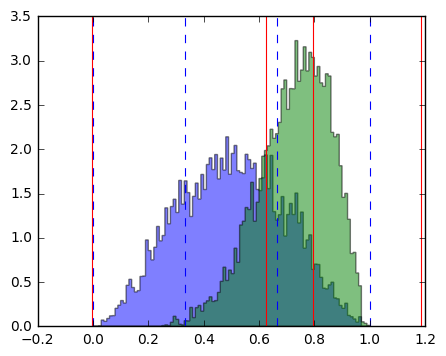

In [21]:
fig = plt.figure(figsize=(5,4))
plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5,normed=True)
plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5,normed=True)
for b in np.sort(results.x):
    plt.axvline(x=b, linewidth=2.0, color='red',lw=0.8)
for b in np.sort(np.linspace (0,1,ncat+1)):
    plt.axvline(x=b, linewidth=2.0, color='blue',lw=0.8, ls='--')
# plt.yscale('log')
plt.show()

In [9]:
results.x, results.fun

(array([ -9.5590e-04,   6.1866e-01,   7.8917e-01,   1.0253e+00]),
 -3.2228787693415382)

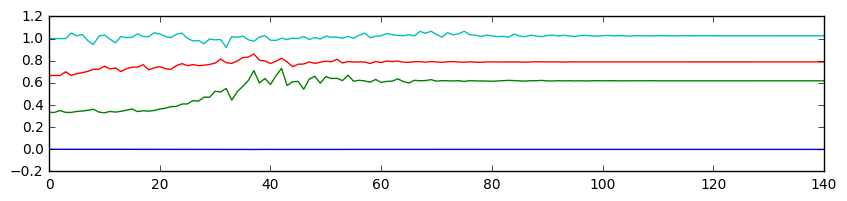

In [10]:
fig = plt.figure(figsize=(10,2))
for ix in range(results.x.shape[0]):
    plt.plot(range(np.array(binner.scan['bounds']).shape[0]), np.array(binner.scan['bounds'])[:,ix] )

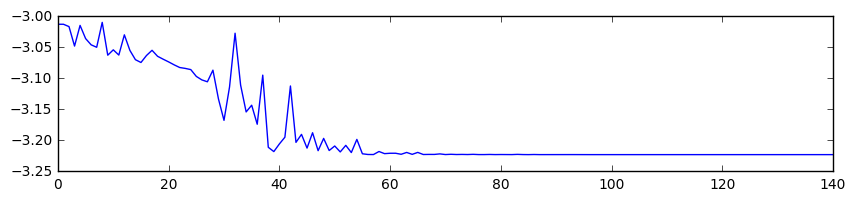

In [11]:
fig = plt.figure(figsize=(10,2))
plt.plot(range(np.array(binner.scan['bounds']).shape[0]), np.array(binner.scan['cost']))

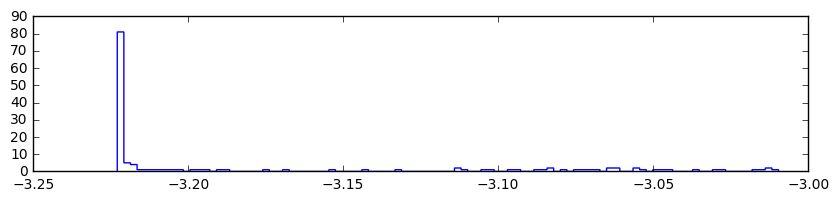

In [12]:
fig = plt.figure(figsize=(10,2))
plt.hist(np.array(binner.scan['cost']),bins=100,
         range=[min(np.array(binner.scan['cost'])),max(np.array(binner.scan['cost']))], 
         histtype='step')
plt.show()

In [13]:
np.sort(results.x)

array([ -9.5590e-04,   6.1866e-01,   7.8917e-01,   1.0253e+00])

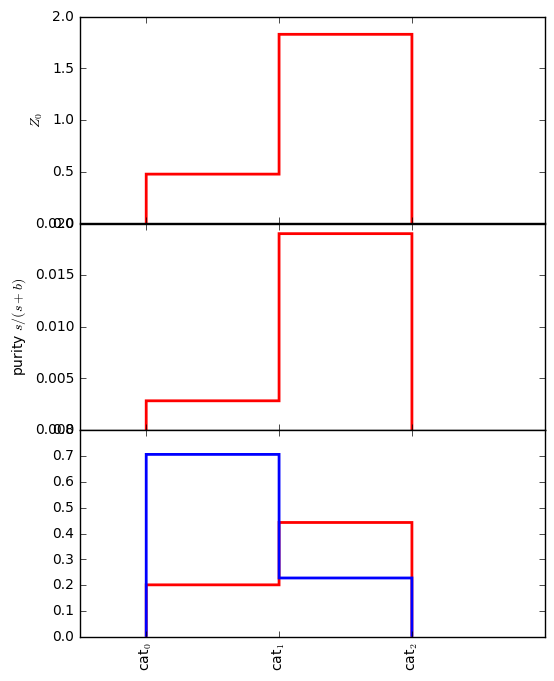

In [14]:
f = plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.001)

labels = ["cat$_{%i}$" % i for i in np.arange(binner.nbins)]
ax1 = plt.subplot(311)
ax1.hist(np.arange(binner.nbins)+0.5,bins= np.arange(binner.nbins),
         weights=binner.binned_score(np.sort(results.x)), 
         linewidth=2.0, color='red', histtype='step')
ax1.set_ylabel("$Z_0$")

ax2 = plt.subplot(312, sharex=ax1)
ws,_  = np.histogram(data[y==1],bins=np.sort(results.x), weights=weight[y==1])
wb,_  = np.histogram(data[y==0],bins=np.sort(results.x), weights=weight[y==0])
ax2.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=ws/(ws+wb), 
         linewidth=2.0, color='red', histtype='step')

ax2.set_ylabel("purity $s/(s+b)$")
ax3 = plt.subplot(313, sharex=ax2)
ax3.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=ws/ws.sum(), 
         linewidth=2.0, color='red', histtype='step')
ax3.hist(np.arange(binner.nbins)+0.5,bins=np.arange(binner.nbins),
         weights=wb/wb.sum(), 
         linewidth=2.0, color='blue', histtype='step')

xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xticks(np.arange(binner.nbins), labels, rotation='vertical')
ax1.set_xlim([-0.5, binner.nbins])
plt.show()

In [15]:
np.sqrt(-results.fun)

1.7952378030059244

In [16]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=30)

z_cv = []
x_cv = []

for (train, test) in cv.split(data, y):
    binner_  = zbinner(3,[0,1])
    result_  = binner_.fit(data[train], y[train], sample_weights = weight[train])
    z_cv.append(result_.fun)
    x_cv.append(result_.x)
    
print x_cv
print z_cv

[array([-0.0021,  0.6188,  0.7879,  1.0247]), array([ -9.5886e-04,   6.2073e-01,   7.8933e-01,   1.0257e+00]), array([-0.0019,  0.6195,  0.7871,  1.0251]), array([-0.0011,  0.6179,  0.7867,  1.0265]), array([-0.0021,  0.6205,  0.7898,  1.0247]), array([ -9.7947e-04,   6.1796e-01,   7.9030e-01,   1.0242e+00]), array([-0.0021,  0.6207,  0.7895,  1.0247]), array([ -7.4833e-04,   6.1876e-01,   7.8709e-01,   1.0245e+00]), array([ -8.8425e-04,   6.1764e-01,   7.8927e-01,   1.0254e+00]), array([ -7.4175e-04,   6.2074e-01,   7.9243e-01,   1.0297e+00]), array([-0.0021,  0.6186,  0.7889,  1.0246]), array([-0.0022,  0.6176,  0.7878,  1.0272]), array([-0.0026,  0.616 ,  0.7869,  1.0255]), array([-0.0026,  0.6177,  0.7891,  1.0267]), array([ -2.4403e-04,   6.1875e-01,   7.8707e-01,   1.1266e+00]), array([ -1.0261e-04,   6.1822e-01,   7.8761e-01,   1.1136e+00]), array([-0.0018,  0.6183,  0.7886,  1.0242]), array([ -1.6214e-04,   6.1972e-01,   7.8920e-01,   1.1386e+00]), array([-0.0025,  0.6193,  0.7

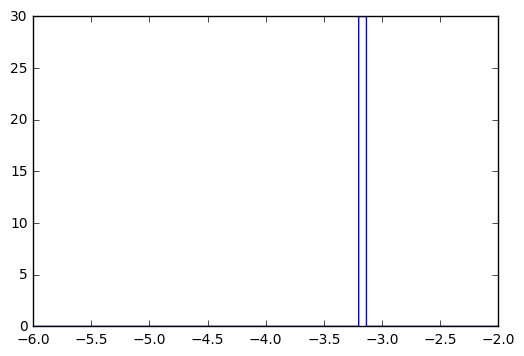

In [17]:
plt.hist(z_cv,bins=60,
         range=[-6,-2], 
         histtype='step')
plt.show()

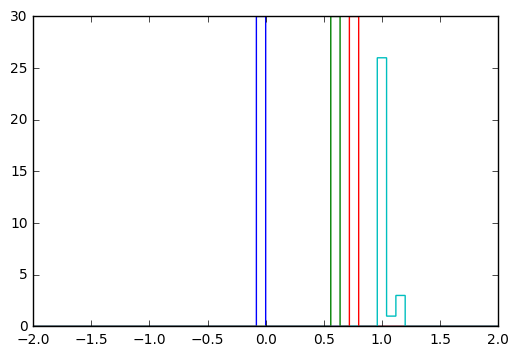

In [18]:
xx_ = np.sort(np.array(x_cv))
for i in range(4):
    plt.hist(xx_.T[i],bins=50,
             range=[-2,2], 
             histtype='step')
plt.show()

In [19]:
from scipy import stats as st
cov = np.zeros((xx_.shape[1],xx_.shape[1]))
for i in range(xx_.shape[1]):
    for j in range(xx_.shape[1]):
        cov[i][j] = st.pearsonr(xx_.T[i], xx_.T[j])[0]

In [20]:
# dir(cov)
print np.linalg.det(cov)
print np.linalg.eig(cov)

0.399850707085
(array([ 0.327 ,  0.4799,  1.5607,  1.6323]), array([[-0.4327,  0.5651, -0.5287, -0.4626],
       [-0.4317, -0.5766,  0.2888, -0.6307],
       [ 0.5762,  0.4005,  0.4441, -0.5571],
       [ 0.5427, -0.4334, -0.6632, -0.279 ]]))


In [21]:
fig = plt.figure(figsize=(5,3))
z_mean = []
z_std  = []
for cat in np.arange(1,7):
    print " --- ", cat
    binner_  = zbinner(cat,[0,1])
    z = []
    for (train, test) in cv.split(data, y):
        result_ = binner_.fit(data[train],y[train],sample_weights=weight[train])
        z.append(result_.fun)
    
    z_mean.append( np.mean(z) )
    z_std.append ( np.std(z)  )

 ---  1
 ---  2
 ---  3
 ---  4
 ---  5
 ---  6


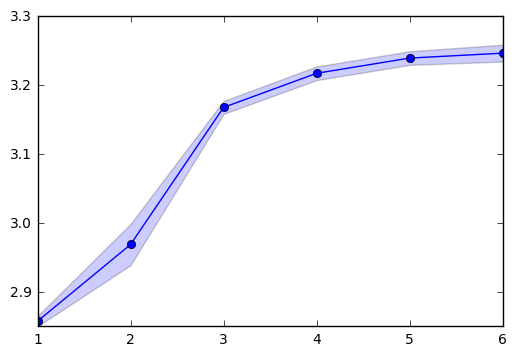

In [22]:
z_mean = np.array(z_mean)
z_std  = np.array(z_std)

plt.plot(np.arange(1,7), -z_mean, 'o-' )
plt.fill_between (np.arange(1,7), -z_mean - z_std, -z_mean + z_std, alpha=0.2)

(0, 1)

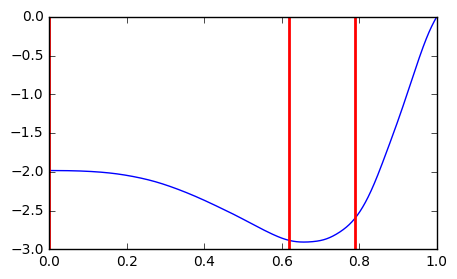

In [23]:
fig = plt.figure(figsize=(5,3))
x = np.arange(0,1, 0.001)
z = []
for ix in x :
    z.append(binner.cost_fun(np.array([ix,1]))  )
plt.plot(x,z)
for b in results.x:
    plt.axvline(x=b, linewidth=2.0, color='red')
    
plt.xlim([0,1])

In [24]:
data.shape, y.shape, weight.shape

((16000,), (16000,), (16000,))

In [92]:
ncat    = 3
binner  = zbinner(ncat,[0,1])

results = binner.fit(data, y, sample_weights = weight)
bb = np.array(binner.scan['bounds'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 16000 but corresponding boolean dimension is 100


ValueError: `dataset` input should have multiple elements.

In [93]:
results

 final_simplex: (array([[  1.6090e+00,   2.2287e+00,   1.4792e+00,   1.0253e+00],
       [ -9.5553e-04,   6.1862e-01,   7.8917e-01,   1.0254e+00],
       [ -9.5597e-04,   6.1863e-01,   7.8918e-01,   1.0252e+00],
       [ -9.5558e-04,   6.1862e-01,   7.8914e-01,   1.0253e+00],
       [ -9.5655e-04,   6.1865e-01,   7.8920e-01,   1.0253e+00]]), array([-3.2229, -3.2229, -3.2229, -3.2229, -3.2229]))
           fun: -3.2228787693415382
       message: 'Optimization terminated successfully.'
          nfev: 141
           nit: 78
        status: 0
       success: True
             x: array([ 1.609 ,  2.2287,  1.4792,  1.0253])

In [27]:
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)

def _fun_(x,y):
    return binner.cost_fun(np.array([-0.0041,x,y,1.1858]))
    
vec_fun_ = np.vectorize(_fun_)    

Z = vec_fun_(X,Y)

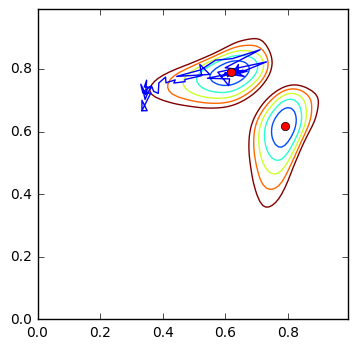

In [28]:
fig = plt.figure(figsize=(4,4))
levels = np.arange(Z.min(),0.95*Z.min(), 0.03)
plt.contour(X, Y, Z,levels, fontsize=9, inline=1)

plt.plot(bb.T[1], bb.T[2])
plt.plot(results.x[1], results.x[2], 'ro')
plt.plot(results.x[2], results.x[1], 'ro')

init :  [ 1.509   2.1387  1.4792  1.0253]
loop :  [ 1.509   2.1387  1.4792  1.0253]
loop :  [ 1.609   2.1387  1.4792  1.0253]


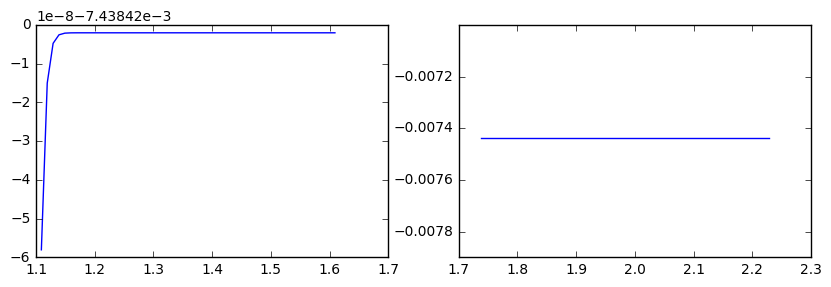

In [91]:
fig = plt.figure(figsize=(10,3))

ax = []
b = results.x
print "init : ", b
for i in range(2):
    ax.append(plt.subplot(121+i))
    t = np.arange(b[i]-0.4,b[i]+0.1,0.01)
    def _fun_(x):
        xx    = results.x
        xx[i] = x
        return binner.cost_fun(xx)
    print "loop : ", results.x
    v_fun_ = np.vectorize(_fun_)
    ax[i].plot(t,v_fun_(t))


In [79]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

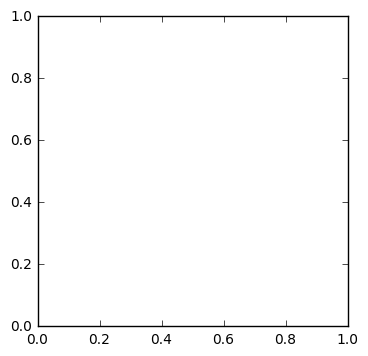

In [65]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw=2)

In [66]:
def init():
    line.set_data([], [])
    return (line,)

In [67]:
def animate(i):
    ax.contour(X, Y, Z,levels, fontsize=9, inline=1)
    ax.plot(bb.T[1][i], bb.T[2][i], 'b.-')
    line.set_data(bb.T[1][i], bb.T[2][i])
    return (line,)

In [68]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [69]:
HTML(anim.to_html5_video())